# Photosynthesis estimation function

## Goal

**Estimate the photosynthetic output of an average *Synechocystis* sp. PCC 6803 cell as input into another model**

## Plan

First option: Use the submitted model version. The model is unalterend (not reduced in size) and the cellular chlorophyll a concentration is only considered for normalizing the pigment concentrations.

### Input
- Light spectrum & intensity (400-700 nm)
- Pigment concentrations: Chlorophyll A, beta-carotene (carotenoids), phycocyanin, and allophycocyanin
- Chlorophyll concentration in sample cuvette

### Output

Concentrations of ATP, NADPH, 3PGA

In [1]:
%matplotlib inline

# Import packages and functions
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from modelbase.ode import Model, Simulator, mca
from modelbase.ode import ratelaws as rl
from modelbase.ode import ratefunctions as rf

from concurrent.futures import ProcessPoolExecutor
from functools import partial
from pathlib import Path
from warnings import warn
from os import listdir
from os.path import join
import sys

# Helper functions
sys.path.append("../Code")
import functions as fnc
import calculate_parameters_restruct as prm
import functions_light_absorption as lip

# Import model functions
from get_current_model import get_model
from functions_custom_steady_state_simulator import simulate_to_steady_state_custom, _find_steady_state, get_response_coefficients, get_response_coefficients_array, get_response_coefficients_df, calculate_ss_Q_red, get_steadystate_y0
from functions_fluorescence_simulation import make_lights, make_adjusted_lights, create_protocol_NPQ, create_protocol_NPQ_short, create_protocol_noNPQ

In [50]:
# sinks = {
#     "terpenes":{ # Stoichiometry according to Mills2020
#         "stoich": {
#             "ATP": -3,
#             "NADPH": -1,
#             "Ho": -5/m.get_parameter("bHo"),
#             "Fd_ox": 4,
#             "Fd_red":-4,
#             "3PGA": -2,
#         },
#         "title": "Isoprene production (energy carrier & 3PGA)",
#         "compound": "Isoprene"
#     },
#     "sucrose":{
#         "stoich": {
#             "NADPH": -2,
#             "Ho": -2/m.get_parameter("bHo"),
#             "ATP": -3,
#             "3PGA": -2
#         },
#         "title": "Sucrose production (energy carrier & 3PGA)",
#         "compound": "Sucrose"
#     },
#     "glycogen":{
#         "stoich": {
#             "NADPH": -1,
#             "Ho": -1/m.get_parameter("bHo"),
#             "ATP": -2,
#             "3PGA": -1
#         },
#         "title": "Glycogen production (energy carrier & 3PGA)",
#         "compound": "Glycogen"
#     },
# }

In [74]:
def get_simulated_photosynthesis_products(
        light: pd.Series,
        pigment_concentrations: pd.Series, # [mg(pigment) mg(chlorophyll a)^-1]
        sample_chl_concentration: float = 0, # [mmol(Chl) m^-3]
        sample_depth = 0.01, # [m] 
        output_concentrations = ["ATP", "NADPH", "3PGA"],
        kBiomass:float=1,
        stoichBiomass={"ATP":-1, "NADPH":-1, "3PGA":-1},
    ) -> dict:
    # Create the model
    m,y0 = get_model(verbose=False, check_consistency=False)

    # Add a consuming reaction for ATP, NADPH, and 3PGA
    m.add_parameter("kBiomass", kBiomass)
    m.add_reaction_from_args(
        rate_name="vBiomass",
        function=rf.mass_action_4,
        stoichiometry={
            "ATP": stoichBiomass["ATP"],
            "NADPH": stoichBiomass["NADPH"],
            "Ho": stoichBiomass["NADPH"]/m.get_parameter("bHo"),
            "3PGA": stoichBiomass["3PGA"]
            },
        args=["ATP", "NADPH", "Ho", "3PGA", "kBiomass"],
        reversible=True,
    )

    # Adjust the incoming light for the sample chlorophyll concentration
    if sample_chl_concentration > 0:
        
        # Estimate the absorption spectrum from the pigment content
        MChl = 893.509 # [g mol^-1]
        cell_absorption = lip.get_pigment_absorption(pigment_concentrations).sum(axis=1) * MChl # [m^2 mmol(Chl)^-1]

        # Adjust the light
        light = lip.get_mean_sample_light(
            light,  # [µmol(Photons) m^-2 s^-1]
            depth=sample_depth, # [m]
            absorption_coef=cell_absorption, # [m^2 mg(chlorophyll a)^-1]
            chlorophyll_sample=sample_chl_concentration,  # [mmol(Chl) m^-3]
        )

    # Update the light and pigments
    m.update_parameters({
        "pfd": light,
        "pigment_content": pigment_concentrations
        })
    
    # Create and initialise the simulator
    s=Simulator(m)
    s.initialise(y0)

    # return s

    # Simulate to steady state
    s,t,y = simulate_to_steady_state_custom(
        s,
        simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True,
        return_simulator=True,
        **fnc.simulator_kwargs["loose"]
    )

    # Get the required concentrations
    if t is not None:
        res = s.get_results_df().loc[:,output_concentrations].iloc[0,:].to_dict()
    else:
        return None

    return res


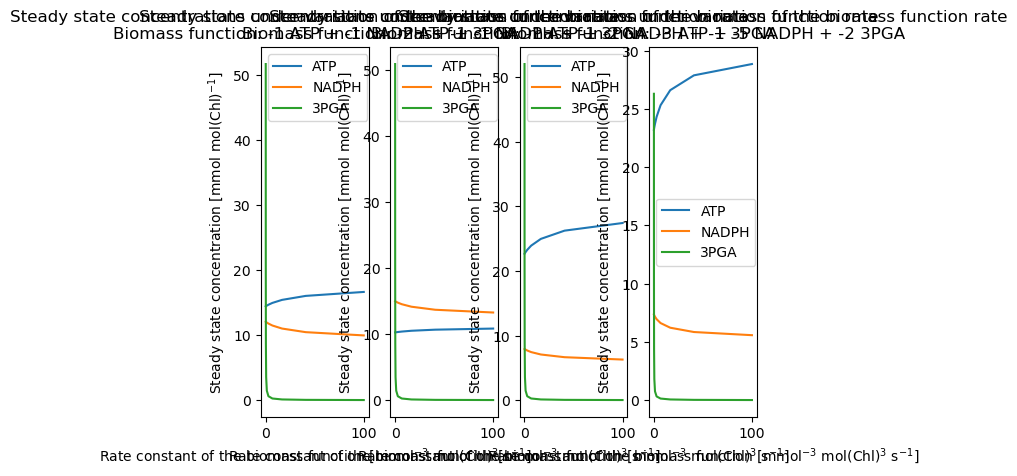

In [77]:
all_stoichBiomass = [
    {"ATP":-1, "NADPH":-1, "3PGA":-1},
    {"ATP":-2, "NADPH":-1, "3PGA":-1}, # Glycogen
    {"ATP":-1, "NADPH":-2, "3PGA":-1},
    {"ATP":-3, "NADPH":-5, "3PGA":-2}, # Isoprene
    ]

fig, axes = plt.subplots(1, len(all_stoichBiomass))

for i,stoichBiomass in enumerate(all_stoichBiomass):
    phots = {}
    ax=axes[i]

    for kBiomass in np.logspace(-1.5,2,10):
        phots[kBiomass] = get_simulated_photosynthesis_products(
            light = lip.light_spectra("warm_white_led", 50),
            pigment_concentrations = lip.pigments_Fuente,
            sample_chl_concentration = 2, # [mmol(Chl) m^-3]
            kBiomass = kBiomass,
            stoichBiomass=stoichBiomass
        )
    phots = pd.DataFrame(phots, dtype=float)

    phots.T.plot(ax=ax)
    ax.set_xlabel("Rate constant of the biomass function [mmol$^{-3}$ mol(Chl)$^{3}$ s$^{-1}$]")
    ax.set_ylabel("Steady state concentration [mmol mol(Chl)$^{-1}$]")
    ax.set_title(f'Steady state concentrations under variation of the biomass function rate\nBiomass function: {stoichBiomass["ATP"]} ATP + {stoichBiomass["NADPH"]} NADPH + {stoichBiomass["3PGA"]} 3PGA')

fig.set_size_inches(20,5)
fig.tight_layout()
fig